211805068 
KAAN ERDEN

In [37]:

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

df = pd.read_csv('eeg.csv')
X = df.drop(['PEGI', 'ESRB'], axis=1)
y_pegi = df['PEGI']
y_esrb = df['ESRB']
feature_names = X.columns

In [38]:
imputed_data_knn = {}
k_values = [3, 5, 10]
for k in k_values:
   
    imputer = KNNImputer(n_neighbors=k)
    X_imputed_np = imputer.fit_transform(X)
    X_imputed_df = pd.DataFrame(X_imputed_np, columns=feature_names)
    imputed_data_knn[f'k={k}'] = X_imputed_df
   
    print(f"k={k} sonrası eksik değer sayısı: {X_imputed_df.isnull().sum().sum()}")
    print("-" * 30)


k=3 sonrası eksik değer sayısı: 0
------------------------------
k=5 sonrası eksik değer sayısı: 0
------------------------------
k=10 sonrası eksik değer sayısı: 0
------------------------------


I handled missing values using K-Nearest Neighbors (KNN) Imputation. The goal was to fill in missing entries in the dataset based on the values of the k nearest samples.
I tried different values of k (3, 5, and 10) to see how they affect the imputation results. For each k, I used KNNImputer from sklearn.impute to fill in the missing data in the feature matrix X.

In [39]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import time 

simple_imputer = SimpleImputer(strategy='median')
X_imputed_simple_np = simple_imputer.fit_transform(X)
X_imputed_simple = pd.DataFrame(X_imputed_simple_np, columns=feature_names)

print(f"SimpleImputer sonrası eksik değer sayısı: {X_imputed_simple.isnull().sum().sum()}")
print("-" * 30)

SimpleImputer sonrası eksik değer sayısı: 0
------------------------------


I used SimpleImputer from sklearn to handle missing values by filling them with the median of each feature.
The goal here was to use a basic and fast method to replace missing values. I chose the median strategy because it's more robust to outliers compared to the mean.

In [40]:
from sklearn.feature_selection import VarianceThreshold
reduced_data_knn_vt = {}
removed_counts_vt = {}
variance_threshold_value = 0.0
selector = VarianceThreshold(threshold=variance_threshold_value)

original_feature_count = X.shape[1]
for k_label, X_imputed in imputed_data_knn.items():
    print(f"Processing KNN Imputed Data ({k_label})...")
    X_reduced_np = selector.fit_transform(X_imputed)
    remaining_feature_count = X_reduced_np.shape[1]
    removed_count = original_feature_count - remaining_feature_count
    remaining_features_mask = selector.get_support()
    remaining_feature_names = X_imputed.columns[remaining_features_mask]
    X_reduced_df = pd.DataFrame(X_reduced_np, columns=remaining_feature_names)
    reduced_data_knn_vt[k_label] = X_reduced_df
    removed_counts_vt[k_label] = removed_count

    print(f"  Orijinal Özellik Sayısı: {original_feature_count}")
    print(f"  Kaldırılan Özellik Sayısı: {removed_count}")
    print(f"  Kalan Özellik Sayısı: {remaining_feature_count}")
    print("-" * 20)




Processing KNN Imputed Data (k=3)...
  Orijinal Özellik Sayısı: 2268
  Kaldırılan Özellik Sayısı: 6
  Kalan Özellik Sayısı: 2262
--------------------
Processing KNN Imputed Data (k=5)...
  Orijinal Özellik Sayısı: 2268
  Kaldırılan Özellik Sayısı: 6
  Kalan Özellik Sayısı: 2262
--------------------
Processing KNN Imputed Data (k=10)...
  Orijinal Özellik Sayısı: 2268
  Kaldırılan Özellik Sayısı: 6
  Kalan Özellik Sayısı: 2262
--------------------


After handling missing values using KNN imputation, I wanted to reduce the number of features by removing those with zero variance  meaning the features that don’t change across the dataset and provide no useful information.

Kullanılan özellik sayısı: 2262
En önemli 5 özellik (PEGI için):
                   feature  importance
2118  RMS_200_POW.F8.Gamma    0.002073
1261  MAX_200_POW.O1.BetaL    0.001960
1877  MIN_200_POW.F4.Theta    0.001688
1346  PTP_200_POW.O2.Theta    0.001681
2012  MIN_200_POW.F8.Theta    0.001612
------------------------------


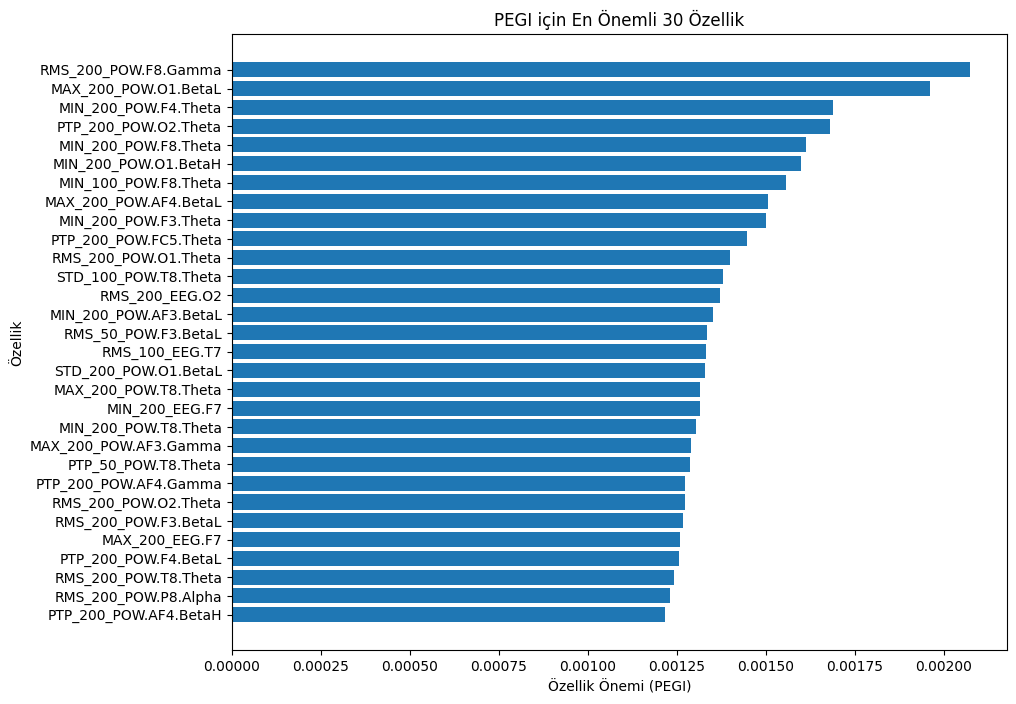

In [41]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np 

X_selected = reduced_data_knn_vt['k=5']
y_target = y_pegi 


print(f"Kullanılan özellik sayısı: {X_selected.shape[1]}")


rf_classifier_pegi = RandomForestClassifier(n_estimators=100, random_state=13, n_jobs=-1) 


rf_classifier_pegi.fit(X_selected, y_target)


importances_pegi = rf_classifier_pegi.feature_importances_
feature_names_pegi = X_selected.columns


feature_importance_df_pegi = pd.DataFrame({'feature': feature_names_pegi, 'importance': importances_pegi})
feature_importance_df_pegi = feature_importance_df_pegi.sort_values(by='importance', ascending=False)


print("En önemli 5 özellik (PEGI için):")
print(feature_importance_df_pegi.head())
print("-" * 30)


top_n = 30
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df_pegi['feature'][:top_n], feature_importance_df_pegi['importance'][:top_n])
plt.xlabel("Özellik Önemi (PEGI)")
plt.ylabel("Özellik")
plt.gca().invert_yaxis() 
plt.title(f"PEGI için En Önemli {top_n} Özellik")
plt.show()

After cleaning and selecting features using KNN imputation (k=5) and VarianceThreshold, I trained a Random Forest Classifier to identify which features are the most useful in predicting PEGI categories.

In [42]:

num_features_to_select_pegi = 100
top_100_features_pegi = feature_importance_df_pegi['feature'].head(num_features_to_select_pegi).tolist()
print(f"PEGI modeli için en önemli {num_features_to_select_pegi} özellik seçildi.")
X_pegi_final = reduced_data_knn_vt['k=10'][top_100_features_pegi]
print(f"PEGI için son özellik matrisinin boyutu: {X_pegi_final.shape}")
print("-" * 30)

PEGI modeli için en önemli 100 özellik seçildi.
PEGI için son özellik matrisinin boyutu: (900, 100)
------------------------------


After getting the feature importance scores from the Random Forest classifier, I selected the top 100 most important features to use in the final model for PEGI classification.

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
X_train_pegi, X_test_pegi, y_train_pegi, y_test_pegi = train_test_split(
    X_pegi_final,
    y_pegi,
    test_size=0.3,
    random_state=13,
    stratify=y_pegi
)

print(f"  Eğitim seti özellikleri boyutu: {X_train_pegi.shape}")
print(f"  Test seti özellikleri boyutu: {X_test_pegi.shape}")
print(f"  Eğitim seti etiketleri dağılımı:\n{y_train_pegi.value_counts(normalize=True)}")
print(f"  Test seti etiketleri dağılımı:\n{y_test_pegi.value_counts(normalize=True)}")
print("-" * 30)

  Eğitim seti özellikleri boyutu: (630, 100)
  Test seti özellikleri boyutu: (270, 100)
  Eğitim seti etiketleri dağılımı:
PEGI
3     0.206349
16    0.200000
7     0.200000
18    0.200000
12    0.193651
Name: proportion, dtype: float64
  Test seti etiketleri dağılımı:
PEGI
3     0.207407
18    0.200000
7     0.200000
16    0.200000
12    0.192593
Name: proportion, dtype: float64
------------------------------


Splits the dataset into 70% training and 30% testing.

stratify=y_pegi ensures that class distribution stays the same in both sets.

random_state=13 is used for reproducibility

------------------------------
------------------------------
PEGI Modeli Performans Değerlendirmesi:
  Doğruluk (Accuracy): 0.7000

  Sınıflandırma Raporu:
              precision    recall  f1-score   support

           3       0.67      0.80      0.73        56
           7       0.63      0.74      0.68        54
          12       0.82      0.63      0.72        52
          16       0.65      0.72      0.68        54
          18       0.80      0.59      0.68        54

    accuracy                           0.70       270
   macro avg       0.72      0.70      0.70       270
weighted avg       0.72      0.70      0.70       270


  Karmaşıklık Matrisi:
[[45  3  0  8  0]
 [ 3 40  2  6  3]
 [ 8  4 33  4  3]
 [ 4  5  4 39  2]
 [ 7 11  1  3 32]]


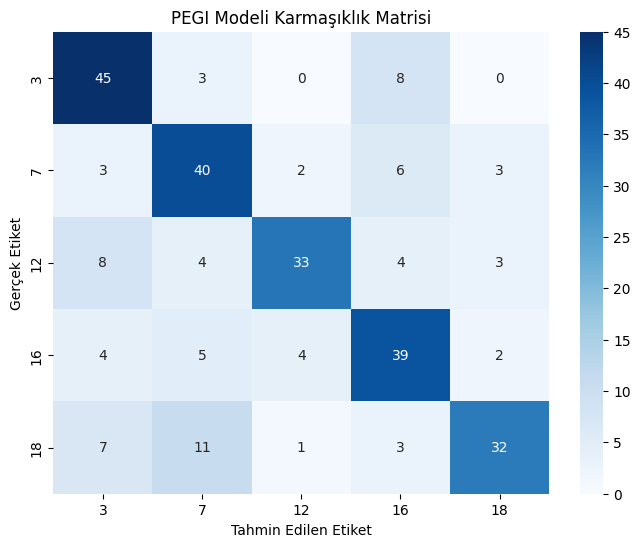

In [44]:

pegi_model = RandomForestClassifier(n_estimators=100, random_state=13, n_jobs=-1)

pegi_model.fit(X_train_pegi, y_train_pegi)

print("-" * 30)

y_pred_pegi = pegi_model.predict(X_test_pegi)

print("-" * 30)
print("PEGI Modeli Performans Değerlendirmesi:")
accuracy_pegi = accuracy_score(y_test_pegi, y_pred_pegi)
print(f"  Doğruluk (Accuracy): {accuracy_pegi:.4f}")
print("\n  Sınıflandırma Raporu:")
print(classification_report(y_test_pegi, y_pred_pegi))
print("\n  Karmaşıklık Matrisi:")
cm_pegi = confusion_matrix(y_test_pegi, y_pred_pegi)
print(cm_pegi)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pegi, annot=True, fmt='d', cmap='Blues',
            xticklabels=pegi_model.classes_, yticklabels=pegi_model.classes_)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('PEGI Modeli Karmaşıklık Matrisi')
plt.show()

After preparing the data and selecting the most important features, I trained a Random Forest Classifier to predict PEGI categories.

In [45]:

selector_simple = VarianceThreshold(threshold=0.0)
feature_names_simple = X_imputed_simple.columns
original_feature_count_simple = len(feature_names_simple)
X_simple_vt_np = selector_simple.fit_transform(X_imputed_simple)
remaining_features_mask_simple = selector_simple.get_support()
remaining_feature_names_simple = feature_names_simple[remaining_features_mask_simple]
X_simple_vt = pd.DataFrame(X_simple_vt_np, columns=remaining_feature_names_simple)

removed_count_simple = original_feature_count_simple - X_simple_vt.shape[1]
print(f"  Orijinal Özellik Sayısı: {original_feature_count_simple}")
print(f"  Kaldırılan Özellik Sayısı (Sıfır Varyans): {removed_count_simple}")
print(f"  Kalan Özellik Sayısı: {X_simple_vt.shape[1]}")
print("-" * 30)


rf_classifier_simple = RandomForestClassifier(n_estimators=100, random_state=13, n_jobs=-1)
rf_classifier_simple.fit(X_simple_vt, y_pegi)

importances_simple = rf_classifier_simple.feature_importances_
feature_names_simple_vt = X_simple_vt.columns

feature_importance_df_simple = pd.DataFrame({'feature': feature_names_simple_vt, 'importance': importances_simple})
feature_importance_df_simple = feature_importance_df_simple.sort_values(by='importance', ascending=False)


print("En önemli 5 özellik (SimpleImputer verisi, PEGI için):")
print(feature_importance_df_simple.head())
print("-" * 30)
num_features_to_select = 100
top_100_features_simple = feature_importance_df_simple['feature'].head(num_features_to_select).tolist()

print(f"SimpleImputer verisi için PEGI modelinde kullanılacak en önemli {num_features_to_select} özellik seçildi.")


X_pegi_final_simple = X_simple_vt[top_100_features_simple]

print(f"SimpleImputer sonrası PEGI için son özellik matrisinin boyutu: {X_pegi_final_simple.shape}") 
print("-" * 30)
X_train_pegi_simple, X_test_pegi_simple, y_train_pegi_simple, y_test_pegi_simple = train_test_split(
    X_pegi_final_simple,
    y_pegi, 
    test_size=0.3,
    random_state=13, 
    stratify=y_pegi
)


print(f"  Eğitim seti boyutu: {X_train_pegi_simple.shape}")
print(f"  Test seti boyutu: {X_test_pegi_simple.shape}")
print("-" * 30)
pegi_model_simple = RandomForestClassifier(n_estimators=100, random_state=13, n_jobs=-1)

pegi_model_simple.fit(X_train_pegi_simple, y_train_pegi_simple)


y_pred_pegi_simple = pegi_model_simple.predict(X_test_pegi_simple)

print("\nSimpleImputer Verisi ile PEGI Modeli Performans Değerlendirmesi:")
accuracy_pegi_simple = accuracy_score(y_test_pegi_simple, y_pred_pegi_simple)
print(f"  Doğruluk (Accuracy): {accuracy_pegi_simple:.4f}")
print("\n  Sınıflandırma Raporu:")
print(classification_report(y_test_pegi_simple, y_pred_pegi_simple))
print("-" * 30)
accuracy_pegi_simple = accuracy_score(y_test_pegi_simple, y_pred_pegi_simple)
print(f"  Doğruluk (Accuracy): {accuracy_pegi_simple:.4f}")

  Orijinal Özellik Sayısı: 2268
  Kaldırılan Özellik Sayısı (Sıfır Varyans): 6
  Kalan Özellik Sayısı: 2262
------------------------------
En önemli 5 özellik (SimpleImputer verisi, PEGI için):
                   feature  importance
1261  MAX_200_POW.O1.BetaL    0.002119
2118  RMS_200_POW.F8.Gamma    0.002073
668   MIN_200_POW.F3.Theta    0.001761
1346  PTP_200_POW.O2.Theta    0.001746
1289  MIN_200_POW.O1.BetaH    0.001614
------------------------------
SimpleImputer verisi için PEGI modelinde kullanılacak en önemli 100 özellik seçildi.
SimpleImputer sonrası PEGI için son özellik matrisinin boyutu: (900, 100)
------------------------------
  Eğitim seti boyutu: (630, 100)
  Test seti boyutu: (270, 100)
------------------------------

SimpleImputer Verisi ile PEGI Modeli Performans Değerlendirmesi:
  Doğruluk (Accuracy): 0.7000

  Sınıflandırma Raporu:
              precision    recall  f1-score   support

           3       0.67      0.70      0.68        56
           7       0.61   

What i did here is ı used SimpleImputer Instead KnnImputer. Before that accuracy result ı used KNNImputer dataset and this is a simpleımputer dataset result

In [46]:

print(f"Kullanılan özellik sayısı: {X_simple_vt.shape[1]}")
y_target_esrb = y_esrb
rf_classifier_esrb = RandomForestClassifier(n_estimators=100, random_state=13, n_jobs=-1)
rf_classifier_esrb.fit(X_simple_vt, y_target_esrb)
importances_esrb = rf_classifier_esrb.feature_importances_
feature_names_esrb_vt = X_simple_vt.columns 
feature_importance_df_esrb = pd.DataFrame({'feature': feature_names_esrb_vt, 'importance': importances_esrb})
feature_importance_df_esrb = feature_importance_df_esrb.sort_values(by='importance', ascending=False)


print("En önemli 5 özellik (ESRB için):")
print(feature_importance_df_esrb.head())
print("-" * 30)

Kullanılan özellik sayısı: 2262
En önemli 5 özellik (ESRB için):
                    feature  importance
2258  PTP_200_POW.AF4.Gamma    0.003089
488    MIN_50_POW.AF3.Gamma    0.002417
507    MA_200_POW.AF3.Gamma    0.002214
495   RMS_100_POW.AF3.Gamma    0.002195
506   MIN_200_POW.AF3.Gamma    0.002110
------------------------------


in this step determine the relative importance of the features used in the `X_simple_vt` dataset for predicting the target variable `y_target_esrb` (presumably ESRB ratings). This helps understand which features contribute most significantly to the model's predictions.

In [47]:
num_features_to_select_esrb = 150
top_100_features_esrb = feature_importance_df_esrb['feature'].head(num_features_to_select_esrb).tolist()
print(f"ESRB modeli için en önemli {num_features_to_select_esrb} özellik seçildi.")
X_esrb_final = X_simple_vt[top_100_features_esrb]
print(f"ESRB için son özellik matrisinin boyutu: {X_esrb_final.shape}")
print("-" * 30)

ESRB modeli için en önemli 150 özellik seçildi.
ESRB için son özellik matrisinin boyutu: (900, 150)
------------------------------


selecting top 150 features for esrb model. and creates a new data frame to input 150 features from X_simple_vt

In [48]:
X_train_esrb, X_test_esrb, y_train_esrb, y_test_esrb = train_test_split(
    X_esrb_final,
    y_esrb, 
    test_size=0.3,
    random_state=13,
    stratify=y_esrb
)

print(f"  Eğitim seti boyutu: {X_train_esrb.shape}")
print(f"  Test seti boyutu: {X_test_esrb.shape}")
print(f"  Eğitim seti ESRB etiket dağılımı:\n{y_train_esrb.value_counts(normalize=True)}")
print(f"  Test seti ESRB etiket dağılımı:\n{y_test_esrb.value_counts(normalize=True)}")
print("-" * 30)

  Eğitim seti boyutu: (630, 150)
  Test seti boyutu: (270, 150)
  Eğitim seti ESRB etiket dağılımı:
ESRB
teen        0.593651
everyone    0.206349
mature      0.200000
Name: proportion, dtype: float64
  Test seti ESRB etiket dağılımı:
ESRB
teen        0.592593
everyone    0.207407
mature      0.200000
Name: proportion, dtype: float64
------------------------------


Used train_test_split to divide the selected ESRB features,Printed the shapes (number of rows and columns) of the resulting X_train_esrb and X_test_esrb sets.


ESRB Modeli Performans Değerlendirmesi:
  Doğruluk (Accuracy): 0.6963

  Sınıflandırma Raporu:
              precision    recall  f1-score   support

    everyone       0.84      0.29      0.43        56
      mature       0.73      0.30      0.42        54
        teen       0.68      0.97      0.80       160

    accuracy                           0.70       270
   macro avg       0.75      0.52      0.55       270
weighted avg       0.72      0.70      0.65       270


  Karmaşıklık Matrisi:
[[ 16   3  37]
 [  2  16  36]
 [  1   3 156]]


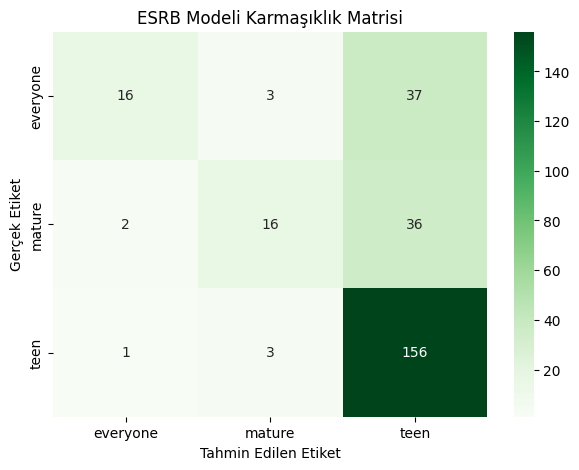

------------------------------


In [49]:

esrb_model = RandomForestClassifier(n_estimators=55, random_state=13, n_jobs=-1)

esrb_model.fit(X_train_esrb, y_train_esrb)


y_pred_esrb = esrb_model.predict(X_test_esrb)

print("\nESRB Modeli Performans Değerlendirmesi:")
accuracy_esrb = accuracy_score(y_test_esrb, y_pred_esrb)
print(f"  Doğruluk (Accuracy): {accuracy_esrb:.4f}")
print("\n  Sınıflandırma Raporu:")
print(classification_report(y_test_esrb, y_pred_esrb))
print("\n  Karmaşıklık Matrisi:")
cm_esrb = confusion_matrix(y_test_esrb, y_pred_esrb, labels=esrb_model.classes_)
print(cm_esrb)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_esrb, annot=True, fmt='d', cmap='Greens',
            xticklabels=esrb_model.classes_, yticklabels=esrb_model.classes_)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('ESRB Modeli Karmaşıklık Matrisi')
plt.show()
print("-" * 30)

I trained a Random Forest Classifier to predict ESRB ratings based on game-related features.And made visualizations.

In [50]:

X_knn10_vt = reduced_data_knn_vt['k=10']
y_target_esrb = y_esrb 
print(f"Kullanılan özellik sayısı: {X_knn10_vt.shape[1]}")
rf_classifier_esrb_knn10 = RandomForestClassifier(n_estimators=100, random_state=13, n_jobs=-1)
rf_classifier_esrb_knn10.fit(X_knn10_vt, y_target_esrb)
importances_esrb_knn10 = rf_classifier_esrb_knn10.feature_importances_
feature_names_esrb_knn10_vt = X_knn10_vt.columns
feature_importance_df_esrb_knn10 = pd.DataFrame({'feature': feature_names_esrb_knn10_vt, 'importance': importances_esrb_knn10})
feature_importance_df_esrb_knn10 = feature_importance_df_esrb_knn10.sort_values(by='importance', ascending=False)

print("En önemli 5 özellik (ESRB, KNN k=10 için):")
print(feature_importance_df_esrb_knn10.head())
print("-" * 30)

Kullanılan özellik sayısı: 2262
En önemli 5 özellik (ESRB, KNN k=10 için):
                    feature  importance
2258  PTP_200_POW.AF4.Gamma    0.002828
488    MIN_50_POW.AF3.Gamma    0.002497
507    MA_200_POW.AF3.Gamma    0.002323
495   RMS_100_POW.AF3.Gamma    0.002195
504   RMS_200_POW.AF3.Gamma    0.002076
------------------------------


I evaluated which features were most important for predicting ESRB ratings after applying feature selection using K-Nearest Neighbors (k=10).Then, I trained a Random Forest Classifier to evaluate feature importances.
After fitting the model, I extracted and sorted feature importances.




In [51]:
num_features_to_select_esrb = 100
top_100_features_esrb_knn10 = feature_importance_df_esrb_knn10['feature'].head(num_features_to_select_esrb).tolist()
print(f"ESRB modeli için (KNN k=10 verisi) en önemli {num_features_to_select_esrb} özellik seçildi.")
X_esrb_final_knn10 = X_knn10_vt[top_100_features_esrb_knn10]
print(f"ESRB için (KNN k=10) son özellik matrisinin boyutu: {X_esrb_final_knn10.shape}")
print("-" * 30)

ESRB modeli için (KNN k=10 verisi) en önemli 100 özellik seçildi.
ESRB için (KNN k=10) son özellik matrisinin boyutu: (900, 100)
------------------------------


After calculating feature importances using the Random Forest classifier, I selected the top 100 most influential features for the ESRB classification task.These features are expected to provide high predictive power with reduced dimensionality.

ESRB (KNN k=10) verisi eğitim ve test setlerine ayrıldı.
  Eğitim seti boyutu: (630, 100)
  Test seti boyutu: (270, 100)
------------------------------
ESRB modeli (RandomForestClassifier) KNN(k=10) verisiyle eğitiliyor...
Model eğitimi tamamlandı.

ESRB (KNN k=10) - Test seti üzerinde tahminler yapılıyor...
Tahminler yapıldı.

ESRB Modeli (KNN k=10 Verisi) Performans Değerlendirmesi:
  Doğruluk (Accuracy): 0.7259

  Sınıflandırma Raporu:
              precision    recall  f1-score   support

    everyone       0.92      0.43      0.59        56
      mature       0.88      0.26      0.40        54
        teen       0.69      0.99      0.81       160

    accuracy                           0.73       270
   macro avg       0.83      0.56      0.60       270
weighted avg       0.78      0.73      0.68       270


  Karmaşıklık Matrisi:
[[ 24   1  31]
 [  1  14  39]
 [  1   1 158]]


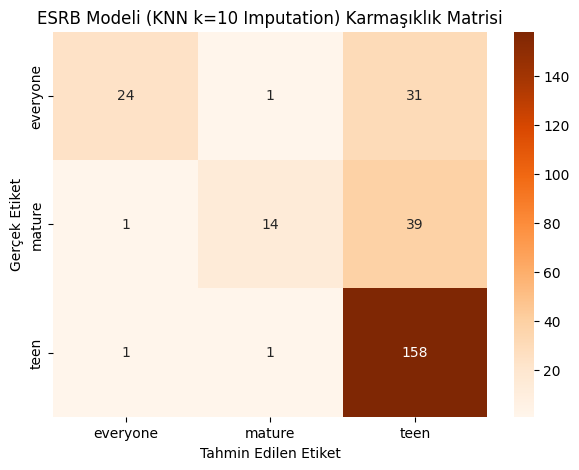

------------------------------


In [52]:
X_train_esrb_knn10, X_test_esrb_knn10, y_train_esrb_knn10, y_test_esrb_knn10 = train_test_split(
    X_esrb_final_knn10,
    y_esrb,
    test_size=0.3,
    random_state=13,
    stratify=y_esrb
)

print("ESRB (KNN k=10) verisi eğitim ve test setlerine ayrıldı.")
print(f"  Eğitim seti boyutu: {X_train_esrb_knn10.shape}")
print(f"  Test seti boyutu: {X_test_esrb_knn10.shape}")
print("-" * 30)
esrb_model_knn10 = RandomForestClassifier(n_estimators=100, random_state=13, n_jobs=-1)
print("ESRB modeli (RandomForestClassifier) KNN(k=10) verisiyle eğitiliyor...")
esrb_model_knn10.fit(X_train_esrb_knn10, y_train_esrb_knn10)
print("Model eğitimi tamamlandı.")
print("\nESRB (KNN k=10) - Test seti üzerinde tahminler yapılıyor...")
y_pred_esrb_knn10 = esrb_model_knn10.predict(X_test_esrb_knn10)
print("Tahminler yapıldı.")
print("\nESRB Modeli (KNN k=10 Verisi) Performans Değerlendirmesi:")
accuracy_esrb_knn10 = accuracy_score(y_test_esrb_knn10, y_pred_esrb_knn10)
print(f"  Doğruluk (Accuracy): {accuracy_esrb_knn10:.4f}")
print("\n  Sınıflandırma Raporu:")
print(classification_report(y_test_esrb_knn10, y_pred_esrb_knn10))
print("\n  Karmaşıklık Matrisi:")
cm_esrb_knn10 = confusion_matrix(y_test_esrb_knn10, y_pred_esrb_knn10, labels=esrb_model_knn10.classes_)
print(cm_esrb_knn10)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_esrb_knn10, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=esrb_model_knn10.classes_, yticklabels=esrb_model_knn10.classes_)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('ESRB Modeli (KNN k=10 Imputation) Karmaşıklık Matrisi')
plt.show()
print("-" * 30)

After selecting the top 100 most important features based on KNN (k=10) reduced data, I trained and evaluated a new Random Forest Classifier. 
The data was split into 70% training and 30% testing.
Stratified sampling was used to maintain class distribution.Used 100 decision trees in the Random Forest.